In [17]:
import numpy as np
import cv2
import json
import matplotlib.path as mpltPath
import os
import warnings
import tifffile
from skimage import exposure
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
from math import sqrt
import matplotlib.pyplot as plt
from glob import glob
from copy import copy
from tqdm.notebook import tqdm
import warnings
import torchstain
import torch
from torchvision import transforms

# 경고 메시지를 무시하도록 설정s
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def preprocessing(img):
    dst_img=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)[:,:,2]
    ret, dst_img = cv2.threshold(dst_img, 127, 255, cv2.THRESH_OTSU)
    dst_img=255-dst_img
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    dst_img = cv2.morphologyEx(dst_img, cv2.MORPH_CLOSE, k)
    return dst_img

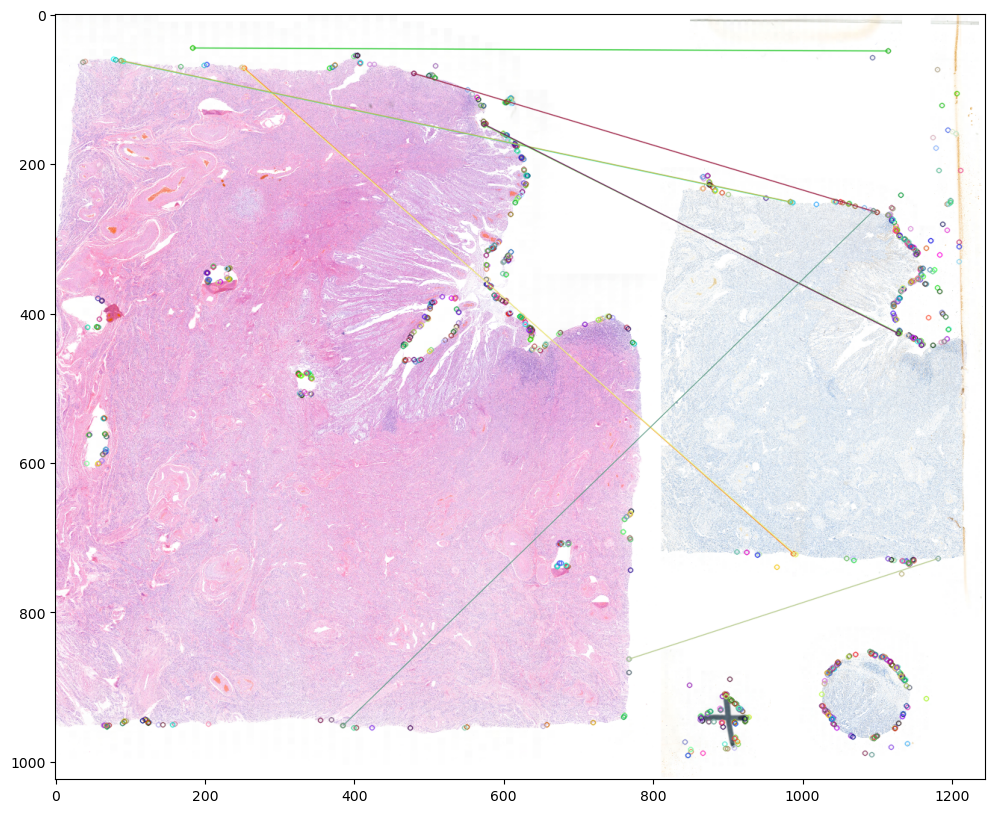

In [43]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')


img1 = np.array(Image.open('../../data/virtual_stain/image_surf/thumb/HE/S22-02375-8.tiff'))
img2 = np.array(Image.open('../../data/virtual_stain/image_surf/thumb/MSH6/S22-02375-8.tiff'))
img1=cv2.resize(img1,(img1.shape[1]//2,img1.shape[0]//2))
img2=cv2.resize(img2,(img2.shape[1]//2,img2.shape[0]//2))
gray1 =preprocessing(img1)
gray2 =preprocessing(img2)

detector = cv2.ORB_create()

# 특징점 검출
keypoints1, descriptors1 = detector.detectAndCompute(gray1, None)
keypoints2, descriptors2 = detector.detectAndCompute(gray2, None)

# Brute-Force 매칭
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# 거리에 따라 매칭 결과를 정렬
matches = sorted(matches, key=lambda x: x.distance)

# 좋은 매칭 포인트를 선택합니다.
num_good_matches = 10  # 예시로 10개의 좋은 매칭 포인트 선택

# 상위 num_good_matches 개의 좋은 매칭 포인트 선택
good_matches = matches[:num_good_matches]


# 매칭 결과를 그리기 위한 이미지를 생성합니다.
result_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None)

# 결과 이미지를 표시합니다.
plt.figure(figsize=(12,12))
plt.imshow(result_img)

In [40]:
matches

()

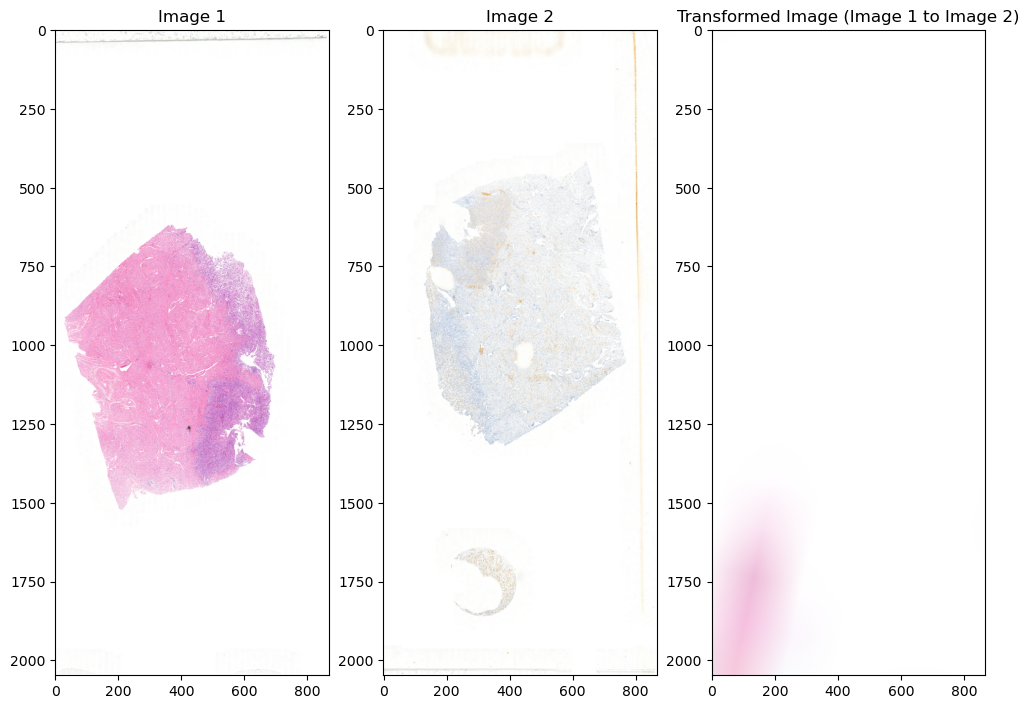

In [31]:
good_kp1 = [keypoints1[m.queryIdx] for m in good_matches]
good_kp2 = [keypoints2[m.trainIdx] for m in good_matches]

# 매칭 포인트의 좌표를 NumPy 배열로 변환
pts1 = np.float32([kp.pt for kp in good_kp1])
pts2 = np.float32([kp.pt for kp in good_kp2])

# Affine 변환 행렬 추정
affine_transform = cv2.estimateAffinePartial2D(pts1, pts2)[0]

# 이미지1을 이미지2에 맞게 변환
result = cv2.warpAffine(img1, affine_transform, (img2.shape[1], img2.shape[0]))

# 변환된 이미지를 출력
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1), plt.imshow(img1), plt.title('Image 1')
plt.subplot(1, 3, 2), plt.imshow(img2), plt.title('Image 2')
plt.subplot(1, 3, 3), plt.imshow(result), plt.title('Transformed Image (Image 1 to Image 2)')
plt.show()

In [158]:
affine_transform

array([[ 8.89668387e-01, -3.05297147e-03,  1.37701203e+01],
       [ 3.05297147e-03,  8.89668387e-01,  1.00967729e+02]])